<div style="text-align: center;"> <h3>Statistical Theory</h3>
<h5>Formative Assessment 10</h5>
<h5><u>By Romand Lansangan</u></h5>
    </div>
    
---

## Introduction
The Cholesterol over Time dataset aims to evaluate whether two brands of margarine (Brand A and Brand B) have different effects on cholesterol levels over time. The dataset includes repeated measurements of cholesterol levels taken at three time points: before starting the intervention, after 4 weeks, and after 8 weeks.

## Methodology
Null Hypothesis ($H_0$): There is no significant difference in cholesterol levels between the two brands of margarine over the three time points.

Alternative Hypothesis ($H_1$): There is a significant difference in cholesterol levels between the two brands of margarine over the three time points.

We ought to test the null hypothesis at a 0.05 significance level. In other words, we ought to reject the null hypothesis if and only if p-value < 0.05. But it is also worth noting the choosing a 0.05 level of significance poses a risk of commiting a type I error (false positive; rejecting null hypothesis when it should be accepted) 5% of the time.

---

In [1]:
import pandas as pd
from scipy.stats import shapiro
from scipy.stats import levene
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from pingouin import anova
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
df = pd.read_csv('Cholesterol_R2.csv')
df.head()

ID  Before  After4weeks  After8weeks Margarine
0   1    6.42         5.83         5.75         B
1   2    6.76         6.20         6.13         B
2   3    6.56         5.83         5.71         B
3   4    4.80         4.27         4.15         A
4   5    8.43         7.71         7.67         B

## Checking for assumptions

### Assumption 1: You have a continuous dependent variable.
In this case, cholesterol levels qualify as a continuous dependent variable.

### Assumption 2: You have one between-subjects factor (i.e., independent variable) that is categorical with two or more categories.
This dataset satisfies this assumption since the margarine brand is categorical with two levels (Brand A and Brand B).

### Assumption 3: You have one within-subjects factor (i.e., independent variable) that is categorical with two or more categories.
The dataset includes repeated measures over time (before, after 4 weeks, and after 8 weeks since initial intervention).

Before proceeding, let us first flatten the dataset based on the combination of brands and intervention period.

In [3]:
df_long = df.melt(
    id_vars=["ID", "Margarine"],
    value_vars=["Before", "After4weeks", "After8weeks"],
    var_name="Time",
    value_name="Cholesterol"
)
df_long.head()

ID Margarine    Time  Cholesterol
0   1         B  Before         6.42
1   2         B  Before         6.76
2   3         B  Before         6.56
3   4         A  Before         4.80
4   5         B  Before         8.43

### Assumption 4: There should be no significant outliers in any cell of the design.
We have used the IQR method to flag outliers. The IQR is computed as follows:

$$
IQR = Q_3 - Q_1
$$

Then the acceptable range for observed data shall be:
$$
(Q_1 - 1.5 \times IQR \  \ , \ \ Q_3 + 1.5 \times IQR) 
$$

Any values outside of this interval shall be flagged as outliers.

In [4]:
grouped = df_long.groupby(['Margarine', 'Time'])

outlier_info = []

for (margarine, time), group in grouped:
    Q1 = group['Cholesterol'].quantile(0.25)
    Q3 = group['Cholesterol'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = group[(group['Cholesterol'] < lower_bound) | (group['Cholesterol'] > upper_bound)]
    
    outlier_info.append({
        'Margarine': margarine,
        'Time': time,
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'Lower Bound': lower_bound,
        'Upper Bound': upper_bound,
        'Outliers': outliers['Cholesterol'].tolist()
    })

outlier_df = pd.DataFrame(outlier_info)
outlier_df

Margarine         Time      Q1      Q3     IQR  Lower Bound  Upper Bound  \
0         A  After4weeks  4.4575  6.9075  2.4500      0.78250     10.58250   
1         A  After8weeks  4.3750  6.8550  2.4800      0.65500     10.57500   
2         A       Before  4.9875  7.3775  2.3900      1.40250     10.96250   
3         B  After4weeks  5.6500  6.3500  0.7000      4.60000      7.40000   
4         B  After8weeks  5.6575  6.2500  0.5925      4.76875      7.13875   
5         B       Before  6.4250  6.8300  0.4050      5.81750      7.43750   

                   Outliers  
0                        []  
1                        []  
2                        []  
3                    [7.71]  
4                    [7.67]  
5  [8.43, 8.05, 5.77, 5.73]

Seeing to it that we have numerous outliers of outliers while having small sample size, it is wise for us to just adjust the value closer to either 1st or 3rd quartile. Upon doing so we are able retain their effects while minimizing it to the point of insignificance.

In [5]:
def winsorize(group):
    Q1 = group['Cholesterol'].quantile(0.25)
    Q3 = group['Cholesterol'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    group['Cholesterol'] = group['Cholesterol'].clip(lower=lower_bound, upper=upper_bound)
    return group

winsorized_data = grouped.apply(winsorize)
winsorized_data

D:\tmp\ipykernel_12376\2828650575.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  winsorized_data = grouped.apply(winsorize)


ID Margarine         Time  Cholesterol
Margarine Time                                                  
A         After4weeks 21   4         A  After4weeks      4.27000
                      23   6         A  After4weeks      7.12000
                      25   8         A  After4weeks      4.63000
                      27  10         A  After4weeks      3.70000
                      30  13         A  After4weeks      5.56000
                      31  14         A  After4weeks      7.11000
                      32  15         A  After4weeks      6.84000
                      34  17         A  After4weeks      4.52000
          After8weeks 39   4         A  After8weeks      4.15000
                      41   6         A  After8weeks      7.05000
                      43   8         A  After8weeks      4.67000
                      45  10         A  After8weeks      3.66000
                      48  13         A  After8weeks      5.51000
                      49  14         A  After8weeks      6.96000
                      50  15         A  After8weeks      6.82000
                      52  17         A  After8weeks      4.45000
          Before      3    4         A       Before      4.80000
                      5    6         A       Before      7.49000
                      7    8         A       Before      5.05000
                      9   10         A       Before      3.91000
                      12  13         A       Before      6.17000
                      13  14         A       Before      7.67000
                      14  15         A       Before      7.34000
                      16  17         A       Before      5.13000
B         After4weeks 18   1         B  After4weeks      5.83000
                      19   2         B  After4weeks      6.20000
                      20   3         B  After4weeks      5.83000
                      22   5         B  After4weeks      7.40000
                      24   7         B  After4weeks      7.25000
                      26   9         B  After4weeks      5.31000
                      28  11         B  After4weeks      6.15000
                      29  12         B  After4weeks      5.59000
                      33  16         B  After4weeks      6.40000
                      35  18         B  After4weeks      5.13000
          After8weeks 36   1         B  After8weeks      5.75000
                      37   2         B  After8weeks      6.13000
                      38   3         B  After8weeks      5.71000
                      40   5         B  After8weeks      7.13875
                      42   7         B  After8weeks      7.10000
                      44   9         B  After8weeks      5.33000
                      46  11         B  After8weeks      5.96000
                      47  12         B  After8weeks      5.64000
                      51  16         B  After8weeks      6.29000
                      53  18         B  After8weeks      5.17000
          Before      0    1         B       Before      6.42000
                      1    2         B       Before      6.76000
                      2    3         B       Before      6.56000
                      4    5         B       Before      7.43750
                      6    7         B       Before      7.43750
                      8    9         B       Before      5.81750
                      10  11         B       Before      6.77000
                      11  12         B       Before      6.44000
                      15  16         B       Before      6.85000
                      17  18         B       Before      5.81750

In [6]:
wide_format = winsorized_data.pivot(index='ID', columns='Time', values='Cholesterol')
wide_format = winsorized_data.pivot(index=['ID', 'Margarine'], columns='Time', values='Cholesterol')
wide_format.columns.name = None
wide_format = wide_format.reset_index()
# wide_format.to_csv('winsorized_data_wide.csv', index=False)

For comparison, here's the before and after winsorizing;
### Before Winsorizing
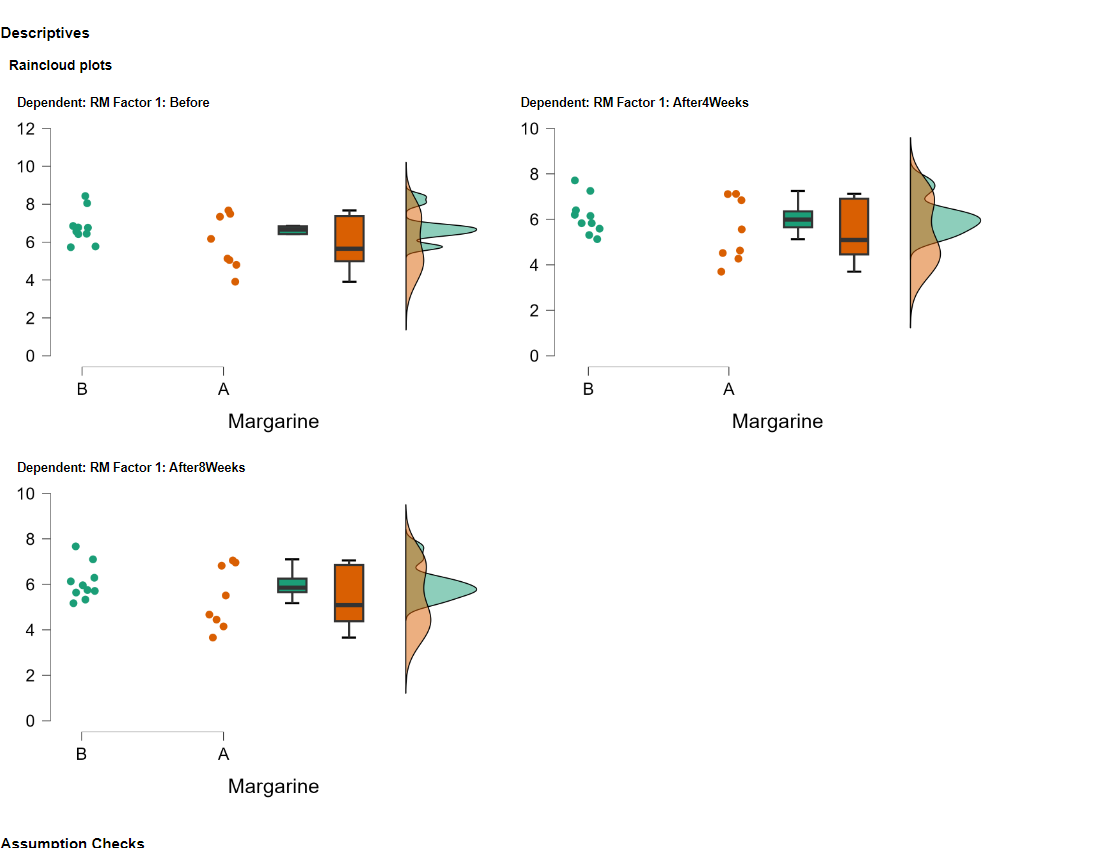

### After Winsorizing
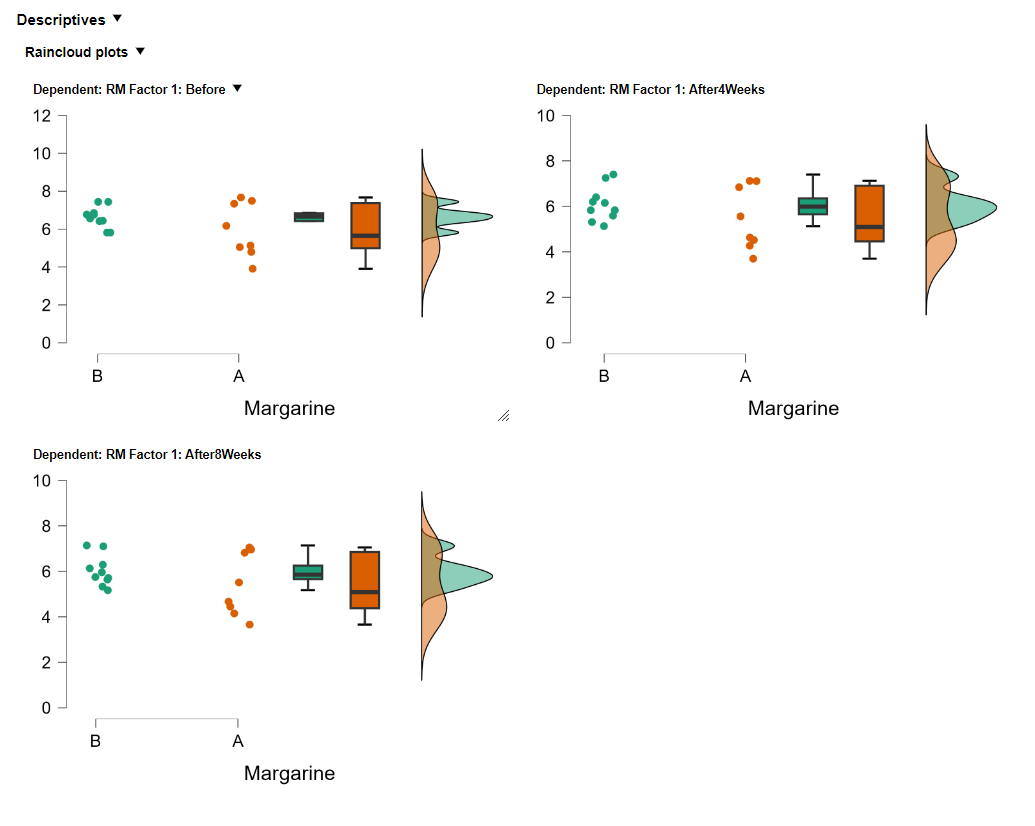

It is kinda weird how the distribution of Margarine B looks before intervention. It looks like it has relatively lower dispersion. Which flag on the potential transgression on homegeneity of variance in between groups, which we shall check later.

### Assumption 5: The dependent variable should be approximately normally distributed for each cell of the design

In [7]:
winsorized_data = winsorized_data.reset_index(drop=True)
cells = winsorized_data.groupby(['Margarine', 'Time'])

for (margarine, time), group in cells:
    stat, p = shapiro(group['Cholesterol'])
    print(f"Cell: Margarine={margarine}, Time={time}")
    print(f"Shapiro-Wilk Test: W={stat:.4f}, p={p:.4f}\n")

Cell: Margarine=A, Time=After4weeks
Shapiro-Wilk Test: W=0.8711, p=0.1544

Cell: Margarine=A, Time=After8weeks
Shapiro-Wilk Test: W=0.8764, p=0.1738

Cell: Margarine=A, Time=Before
Shapiro-Wilk Test: W=0.9005, p=0.2922

Cell: Margarine=B, Time=After4weeks
Shapiro-Wilk Test: W=0.9281, p=0.4293

Cell: Margarine=B, Time=After8weeks
Shapiro-Wilk Test: W=0.9089, p=0.2732

Cell: Margarine=B, Time=Before
Shapiro-Wilk Test: W=0.9196, p=0.3538



### Assumption 6: The variance of your dependent variable should be equal between the groups of the between-subjects factor, referred to as the assumption of homogeneity of variances

We ought to use levene's test for homogeneity because we are comparing "between groups."

In [10]:
stat, p = levene(
    winsorized_data[winsorized_data['Margarine'] == 'A']['Cholesterol'],
    winsorized_data[winsorized_data['Margarine'] == 'B']['Cholesterol']
)

print(f"Levene's Test Statistic: {stat:.4f}, p-value: {p:.4f}")

if p > 0.05:
    print("The assumption of homogeneity of variances is met (p > 0.05).")
else:
    print("The assumption of homogeneity of variances is violated (p <= 0.05).")

Levene's Test Statistic: 18.6086, p-value: 0.0001
The assumption of homogeneity of variances is violated (p <= 0.05).


As was noted earlier, the data does indeed violate the homegeneity of variances according to Levene's test. We shall use log transformation and see if it resolves the issue.

In [11]:
import numpy as np

winsorized_data['Log_Cholesterol'] = np.log(winsorized_data['Cholesterol'])

stat, p = levene(
    winsorized_data[winsorized_data['Margarine'] == 'A']['Log_Cholesterol'],
    winsorized_data[winsorized_data['Margarine'] == 'B']['Log_Cholesterol']
)

print(f"Levene's Test Statistic (Log Transformed): {stat:.4f}, p-value: {p:.4f}")

Levene's Test Statistic (Log Transformed): 27.8151, p-value: 0.0000


## Two-way Anova

In [9]:
aov = anova(dv='political_interest', between=['gender', 'education_level'], data=df, detailed=True)
aov['p'] = aov['p-unc'].apply(lambda x: "< 0.001" if x < 0.001 else f"{x:.4f}")
SS_residual = aov.loc[aov['Source'] == 'Residual', 'SS'].values[0]
aov['partial_eta_sq'] = aov['SS'] / (aov['SS'] + SS_residual)
aov.drop(columns=['np2', 'omega_sq'], inplace=True, errors='ignore')  # Drop if they exist
aov = aov[['Source', 'SS', 'DF', 'MS', 'F', 'p', 'partial_eta_sq']]

aov

KeyError: 'political_interest'

As we can notice, there is not a statistically significant evidence among genders'political interest with p=.3922. Although, among education level, there is in fact a difference in their average political interest score average, p<0.001. However, it is important to see if there's an interaction effect between the two factors, gender and educational level. Meaning, if the effect of the gender in political interest of person depends on the educational level. The result of two-way Anova indicates that there is indeed an interaction effect between the two, p=0.0016. To examine the degree of the effect of educational level within gender, a simple main effects analaysis is imperative with Bonferroni Adjustments to make up for possible type I error inflation.

$$
\alpha_adjusted = \frac{\alpha}{m} = \frac{0.05}{3} \approx 0.0167
$$
Where $\alpha$ is the original level of significance and $m$ is combination of 2 groups of 3 educational level ($\binom{3}{2}= 3$). Therefore, we are now accepting at a significance level of 0.0167.

In [ ]:
for g in df['gender'].unique():
    subset = df[df['gender'] == g]
    print(f"\nSimple Main Effect of Education Level for {g}:")
    aov_2 = anova(dv='political_interest', between='education_level', data=subset, detailed=True)
    print(aov_2)

The result of simple main effect of educational level to gender indicates that education level indeed has an extremely strong effect on political interest on both genders with both male and female having p < 0.001. A very high $n^2_p$ also means that education level explains a significant portion of variability in both genders with male $n^2_p=0.96$ and female $n^2_p=0.76$. With that being said, let's proceed to post hoc analysis.

## Tukey’s HSD Post Hoc

In [ ]:
df['group'] = df['gender'] + "-" + df['education_level'] 
tukey = pairwise_tukeyhsd(endog=df['political_interest'], groups=df['group'], alpha=0.0167)

print(tukey.summary())

In [ ]:
descriptives = df.groupby(['gender', 'education_level']).agg(
    N=('political_interest', 'size'),
    Mean=('political_interest', 'mean'),
    SD=('political_interest', 'std'),
    SE=('political_interest', lambda x: x.std() / (len(x) ** 0.5)), 
    Coefficient_of_variation=('political_interest', lambda x: x.std() / x.mean())  
).reset_index()

descriptives = descriptives.round(3)
descriptives

## Reporting
A two-way ANOVA was conducted to analyze the effects of gender and eucation level on political interests of students. Residualt analysis was done to test for assumptions before conducting two-way ANOVA. The outliers were assessed through IQR method and inspection of boxplot, the result from both method showed no sign of any signicant outliers. A Shapiro-Wilk test was also done to test for normality of the residual distributions and they beg no deviation from normality (*p>.05*). A Levene's test was done to test for homogeneity of variance and we have fail to reject the null hypothesis of having homogeneity of variances (*p=.07*). 

The result of the two-way ANOVA testing showed a statistically significant interaction between gender and level of education in politics (*F(2,52)=7.315, p=.002, patial n^2=.220*). Therefore, an analysis of simple main effects for education level was also performed with Bonferroni adjustment and acceptance at the p < 0.0167 level. The result of the simple main effects showed a significant difference in mean "Polical Interest" scores for males under either school, college, or university level (*F(2,52)=266.29, p<.0001, patial $\eta^2$=.96*). It is the same case for females under school, college, or university level (*F(2,52)=42.97, p<.0001, patial $\eta^2$=.76*). School-educated famales also has statistically significant lower mean "Political Interest" score than univeristy-educated females (*F(2,52)=42.97, p<.0001, patial $\eta^2$=.76*) 

All pairwise comparisons were done for each simple main effect with reported 95% confidence intervals and p-values Bonferonni-adjsuted within each simple main effect. The mean "Political Interest" for school-eduated, college-educated, and university-educated females were $39.60 \pm 3.27, \ 44.60 \pm 3.27, \ 58.00 \pm 6.46$, respectively. There isn't a statistically significant difference between "Political Interest" of college-educated females and school-educated females (*M=-5, p=.051, CI [-10.723, 0.723]*). However, college-educated females have a statitically signifant lower mean "Political Interest" score than university-educated females (*M=18.4, p<.001, CI [12.677, 24.123]*). However, college-educated females have a statitically signifant lower mean "Political Interest" score than university-educated females (*M=13.4, p<.001, CI [7.677, 19.123]*) 

The mean "Political Interest" for school-eduated, college-educated, and university-educated males were $37.44 \pm 2.51, \ 42.94 \pm 2.34, \ 64.10 \pm 3.07$, respectively. There isn't a statistically significant difference between "Political Interest" of college-educated females and school-educated females (*M=-5.500, p=.0371, CI [-11.532, 0.532]*). It is the case, however, that college-educated males' mean "Political Interest" score is lower than those university-educated males (*M=21.156, p<0.001, CI [15.276, 27.035]*). It is also the case that school-educate males have lower mena "Political Interest" score than university-educated males (*M=56.656, p<0.001, CI [20.776, 32.535]*).